In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import random
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [18]:
# read the data
df = pd.read_csv('data/result.csv')

In [19]:
# prepare the data
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
print(X.shape, y.shape)
print(X.head())
print(y.head())

(500, 10) (500,)
   SEC1 Temperature   SEC1 Pressure   SEC2 Temperature   SEC2 Pressure  \
0               498           0.538                472           0.602   
1               570           0.108                579           0.228   
2               565           0.666                524           0.046   
3               552           0.812                582           0.779   
4               503           0.902                504           0.371   

    SEC3 Temperature   SEC3 Pressure   SEC4 Temperature   SEC4 Pressure  \
0                566           0.478                577           0.631   
1                499           0.091                538           0.212   
2                588           0.323                518           0.333   
3                470           0.304                571           0.362   
4                575           0.930                574           0.928   

    Flow Rate   split ratio  
0        1089         0.455  
1         906         0.467

In [20]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [21]:
# scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# y_train = scaler.fit_transform(y_train.values.reshape(-1, 1))
# y_test = scaler.transform(y_test.values.reshape(-1, 1))
# y_train = y_train.reshape(-1)
# y_test = y_test.reshape(-1)
y_train = y_train
y_test = y_test
print(X_train.shape, X_test.shape)
print(X_train[:5])
print(X_test[:5])

(400, 10) (100, 10)
[[ 0.70254476 -1.11875595 -0.43043274  0.85139186 -0.10038016  0.8434679
  -1.70495811  1.50729325 -1.09714496  0.98728198]
 [ 1.47238411  1.36585518 -1.31967553 -0.40116232 -1.33287865  0.52713449
  -1.16052571 -0.79547864  0.25986798 -0.7911467 ]
 [ 0.6494524  -1.28483959 -1.16275033  0.40556749  0.03656412  0.51307522
  -0.15332577  0.63244105 -0.21508655  0.44528467]
 [-0.43894116 -0.17540092 -0.11658235  0.92923421 -1.41504522 -1.06859185
   0.41832825  0.74640647 -1.2158836  -1.33314401]
 [ 1.47238411 -0.63379175 -0.82274574  1.5236667  -0.53860184 -1.24784745
  -0.94275275  0.55869872 -1.16499561 -0.94358344]]
[[-1.66006563  0.22652147  1.24343604  0.14019584  1.54295118  1.58860884
  -0.83386627 -0.48710162  0.76874783 -1.36701884]
 [ 1.10073753  0.57861877 -1.03197933 -0.2207096  -0.0729913   0.85401235
   1.0444255   0.50841985  0.2937933   0.56384658]
 [-1.23532668  1.09347803 -0.27350754 -0.66299568  0.25567497 -0.26018423
   0.49999311 -0.59436319 -0.99

In [22]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

In [23]:
# data loader
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([64, 10]) torch.Size([64])


In [24]:
# build the network
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

class ANN(nn.Module):
    def __init__(self, in_features=10, hidden1=128, hidden2=64, hidden3=32, out_features=1):
        super(ANN, self).__init__()
        # Increase the complexity by adding more layers and more neurons in each layer
        self.fc1 = nn.Linear(in_features, hidden1) 
        self.bn1 = nn.BatchNorm1d(hidden1)  # Batch normalization
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.bn2 = nn.BatchNorm1d(hidden2)  # Batch normalization
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.dropout = nn.Dropout(0.3)  # Dropout for regularization
        self.out = nn.Linear(hidden3, out_features)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)  # Apply dropout
        x = F.relu(self.fc3(x))
        x = self.out(x)
        return x

# Neural Network Model
# class ANN(nn.Module):
#     def __init__(self):
#         super(ANN, self).__init__()
#         self.fc1 = nn.Linear(10, 64)  # 10 features
#         self.fc2 = nn.Linear(64, 64)
#         self.fc3 = nn.Linear(64, 1)   # Predicting a single value

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

cuda:0


In [25]:
# setting of the network
torch.manual_seed(42)
model = ANN()
model.to(device)
print(model)

# loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
epochs = 100

ANN(
  (fc1): Linear(in_features=10, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


In [26]:
# train function
def train(model, opt, criterion, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    model.train()
    for i in range(epochs):
        train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            # zero the parameter gradients
            opt.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            opt.step()
            train_loss.append(loss.item())
        train_loss = np.mean(train_loss)
        test_loss = []
        model.eval()
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)
        # save losses
        train_losses[i] = train_loss
        test_losses[i] = test_loss
        # scheduler.step()
        print(f'Epoch {i+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    return train_losses, test_losses

In [27]:
# train the model
train_losses, test_losses = train(model, optimizer, criterion, train_loader, test_loader, epochs)

Epoch 1/100, Train Loss: 0.3932, Test Loss: 0.4856
Epoch 2/100, Train Loss: 0.3402, Test Loss: 0.1507
Epoch 3/100, Train Loss: 0.0568, Test Loss: 0.0709
Epoch 4/100, Train Loss: 0.0701, Test Loss: 0.0170
Epoch 5/100, Train Loss: 0.0236, Test Loss: 0.0424
Epoch 6/100, Train Loss: 0.0266, Test Loss: 0.0185
Epoch 7/100, Train Loss: 0.0146, Test Loss: 0.0186
Epoch 8/100, Train Loss: 0.0148, Test Loss: 0.0155


d:\anaconda\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\anaconda\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\anaconda\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([36])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_lo

Epoch 9/100, Train Loss: 0.0120, Test Loss: 0.0176
Epoch 10/100, Train Loss: 0.0108, Test Loss: 0.0137
Epoch 11/100, Train Loss: 0.0105, Test Loss: 0.0130
Epoch 12/100, Train Loss: 0.0089, Test Loss: 0.0134
Epoch 13/100, Train Loss: 0.0084, Test Loss: 0.0122
Epoch 14/100, Train Loss: 0.0078, Test Loss: 0.0116
Epoch 15/100, Train Loss: 0.0075, Test Loss: 0.0119
Epoch 16/100, Train Loss: 0.0073, Test Loss: 0.0114
Epoch 17/100, Train Loss: 0.0067, Test Loss: 0.0109
Epoch 18/100, Train Loss: 0.0068, Test Loss: 0.0105
Epoch 19/100, Train Loss: 0.0065, Test Loss: 0.0104
Epoch 20/100, Train Loss: 0.0057, Test Loss: 0.0098
Epoch 21/100, Train Loss: 0.0056, Test Loss: 0.0096
Epoch 22/100, Train Loss: 0.0053, Test Loss: 0.0088
Epoch 23/100, Train Loss: 0.0050, Test Loss: 0.0087
Epoch 24/100, Train Loss: 0.0050, Test Loss: 0.0083
Epoch 25/100, Train Loss: 0.0052, Test Loss: 0.0085
Epoch 26/100, Train Loss: 0.0048, Test Loss: 0.0081
Epoch 27/100, Train Loss: 0.0042, Test Loss: 0.0078
Epoch 28/100,

[0.39324232 0.34015692 0.05675123 0.07008678 0.02359055 0.02662525
 0.01459685 0.01477302 0.01202806 0.01078599 0.01051441 0.00893789
 0.00843642 0.0077684  0.00746207 0.00729254 0.00671057 0.00678041
 0.00654282 0.00571153 0.00561012 0.00533333 0.00501855 0.00497587
 0.00520278 0.00482257 0.00423612 0.00411298 0.00411628 0.00401814
 0.00378693 0.00364186 0.00333588 0.0034418  0.00317566 0.00311627
 0.00314193 0.00284946 0.00287716 0.00265236 0.00264944 0.00261353
 0.00247013 0.00243344 0.00247838 0.00246617 0.00223919 0.00215137
 0.00210627 0.00221304 0.00210284 0.00213752 0.00213424 0.00208858
 0.00193516 0.00201018 0.00193426 0.00192691 0.00201533 0.00214181
 0.00192291 0.00184736 0.0017917  0.00184536 0.00177901 0.00184927
 0.0022612  0.00193692 0.0017701  0.00197652 0.00172846 0.00169498
 0.00169283 0.00170814 0.00164448 0.00179549 0.00164629 0.00167581
 0.00165864 0.00165539 0.00168976 0.00171614 0.00197803 0.00165161
 0.00163932 0.00162804 0.00161682 0.00171469 0.0017049  0.0016

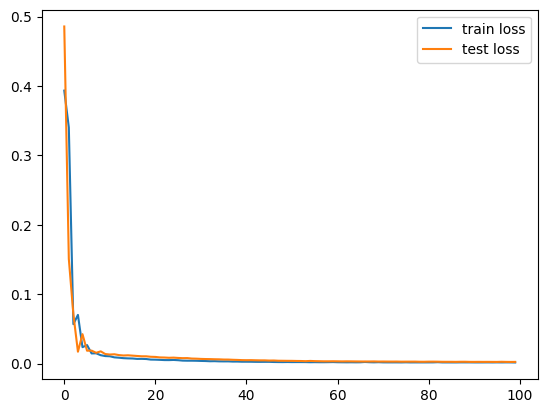

In [28]:
print(train_losses)
print(test_losses)
import matplotlib.pyplot as plt
# plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
# save the figure to figures folder
plt.savefig('figures/loss.png')
plt.show()


In [29]:
from sklearn.metrics import accuracy_score

# Assuming model, X_train, X_test, y_train, y_test are already defined
# and 'device' is your CUDA device (like torch.device("cuda:0"))

with torch.no_grad():
    # Move X_train and X_test to the device
    X_train = X_train.to(device)
    X_test = X_test.to(device)

    # Get predictions
    p_train = model(X_train)
    p_test = model(X_test)

    # Move predictions back to CPU and convert to NumPy arrays
    p_train = p_train.cpu().numpy()
    p_test = p_test.cpu().numpy()
    
    # save the predictions and actual values to csv
    np.savetxt('data/nn_predictions.csv', p_test, delimiter=',')
    np.savetxt('data/nn_actual.csv', y_test, delimiter=',')

# Print predictions and actual values
print('Predict is', p_test)
print('The real is', y_test)

Predict is [[0.6695221 ]
 [0.6607568 ]
 [0.6834831 ]
 [0.6601394 ]
 [0.6373993 ]
 [0.6290626 ]
 [0.70060796]
 [0.62353027]
 [0.6937419 ]
 [0.662381  ]
 [0.65864635]
 [0.67153126]
 [0.6775847 ]
 [0.6430305 ]
 [0.6742694 ]
 [0.6823322 ]
 [0.7309149 ]
 [0.6645586 ]
 [0.63440716]
 [0.7140456 ]
 [0.6566066 ]
 [0.73879945]
 [0.6650671 ]
 [0.63887006]
 [0.6907289 ]
 [0.60219675]
 [0.66422135]
 [0.7448128 ]
 [0.6795473 ]
 [0.6447229 ]
 [0.658735  ]
 [0.6582636 ]
 [0.6491904 ]
 [0.6638724 ]
 [0.6665879 ]
 [0.7368887 ]
 [0.7638992 ]
 [0.74418163]
 [0.6869433 ]
 [0.68915945]
 [0.63228434]
 [0.6349882 ]
 [0.6811096 ]
 [0.69591826]
 [0.6562249 ]
 [0.75460136]
 [0.666962  ]
 [0.6548787 ]
 [0.66803634]
 [0.65560347]
 [0.66187364]
 [0.62919766]
 [0.6532137 ]
 [0.6191417 ]
 [0.61941916]
 [0.663735  ]
 [0.6839926 ]
 [0.6761978 ]
 [0.6765575 ]
 [0.69402343]
 [0.636191  ]
 [0.6701265 ]
 [0.7023367 ]
 [0.6810611 ]
 [0.67275995]
 [0.6657048 ]
 [0.7444288 ]
 [0.59944147]
 [0.6796183 ]
 [0.6899583 ]
 [0.69265

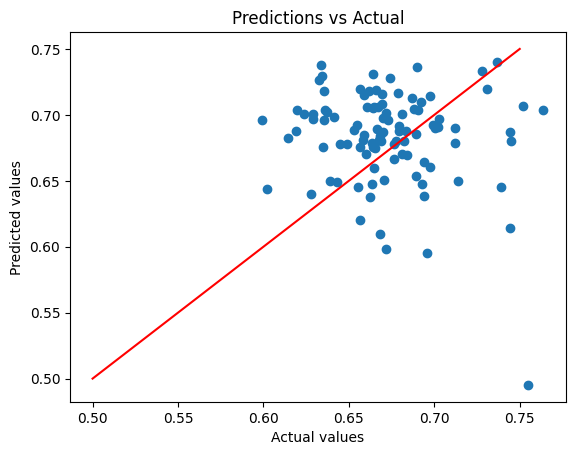

In [30]:
# draw the p_test and y_test by scatter plot
import matplotlib.pyplot as plt
plt.scatter(p_test, y_test)
plt.plot([0.5, 0.75], [0.5, 0.75], color='red')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Predictions vs Actual')
# save the figure to figures folder
plt.savefig('figures/nn_prediction vs Acutural.png')

In [31]:
# save the train and test loss to csv
np.savetxt('data/nn_train_losses.csv', train_losses, delimiter=',')
np.savetxt('data/nn_test_losses.csv', test_losses, delimiter=',')

In [32]:
# save the model to checkpoint folder
torch.save(model.state_dict(), 'checkpoint/model1.pth')